In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import skimage as sk
from skimage.io import imread, imsave, imshow
import skimage.transform

In [2]:
def load_image(href_or_dir):
    img = imread(href_or_dir, 0)
    return np.array(img, dtype=float) # float для предотвращения отсечения значений


def visualize(imgs, format=None, scale=1):
    plt.figure(figsize=(20*scale, 40*scale))
    if type(imgs) != list:
        plt.imshow(imgs, cmap=format)
        plt.show()
        return 
    
    for i, img in enumerate(imgs):
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(3, 3, plt_idx)    
        plt.imshow(img, cmap=format)
    plt.show()

#### Сопоставление фотографий Прокудина-Горского
- Ссылка на галерею с фото http://www.loc.gov/pictures/search/?q=Prokudin&co=prok
- Входное изображение представляет собой набор из 3 пластин, соответствующих каналам B, G и R (сверху вниз).

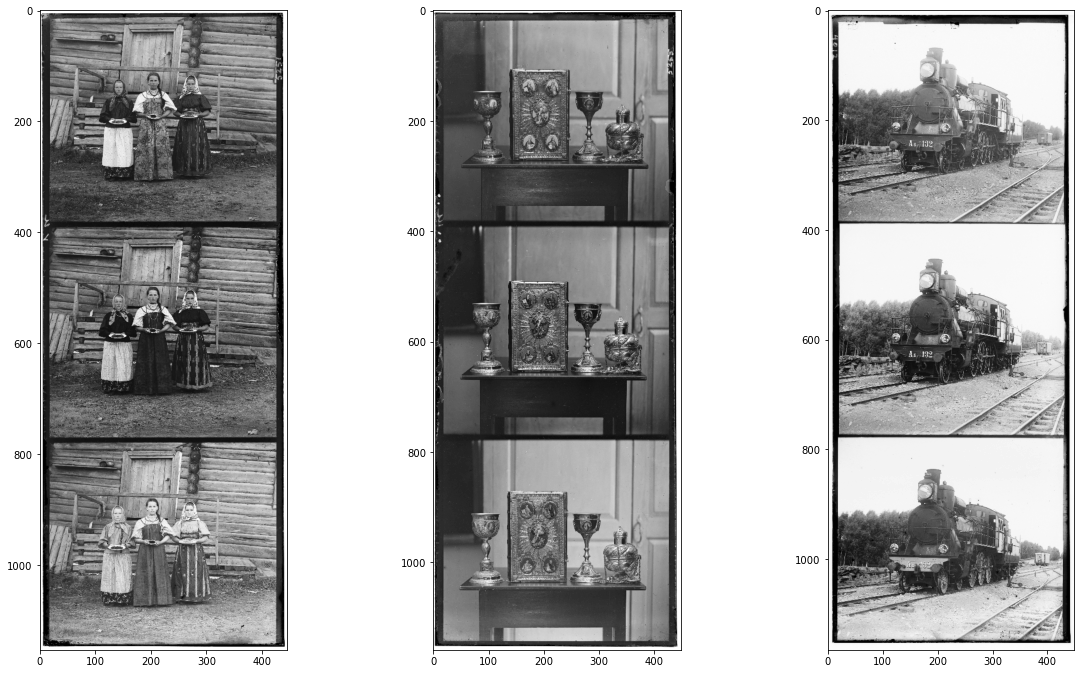

In [3]:
images = [load_image('https://stepik.org/media/attachments/lesson/58182/04.png'),
          load_image('https://stepik.org/media/attachments/lesson/58182/05.png'),
          load_image('https://stepik.org/media/attachments/lesson/58182/03.png'),
]

visualize(images, 'gray')

В большинстве изображений присутствует обрамление со всех сторон. 
Такое обрамление может заметно ухудшить качество выравнивания каналов. 

Нужно разделить изображение на три канала **(B, G, R)** и сделать одно цветное изображение
<img src="https://user-images.githubusercontent.com/54672403/124641168-104f6a00-de97-11eb-87cc-6041dc0dc1c7.jpg" style="height:450px">

In [4]:
def impose_components(img, cut=0.05):
    height, width = img.shape
    height = height - (height % 3) # Делает высоту изображения кратной 3
    
    dx = int(height // 3 * cut)
    dy = int(width * cut)
    channel_height = height // 3

    r = img[-channel_height+dx:-dx, dy:-dy]
    g = img[ channel_height+dx: channel_height*2-dx, dy:-dy]
    b = img[dx:channel_height-dx, dy:-dy]
    
    # assert r.shape==g.shape==b.shape, "Размеры RGB каналов не совпали, ошибка в объединении матриц"
    merged = np.dstack((r,g,b))
    return merged.astype(np.int32)

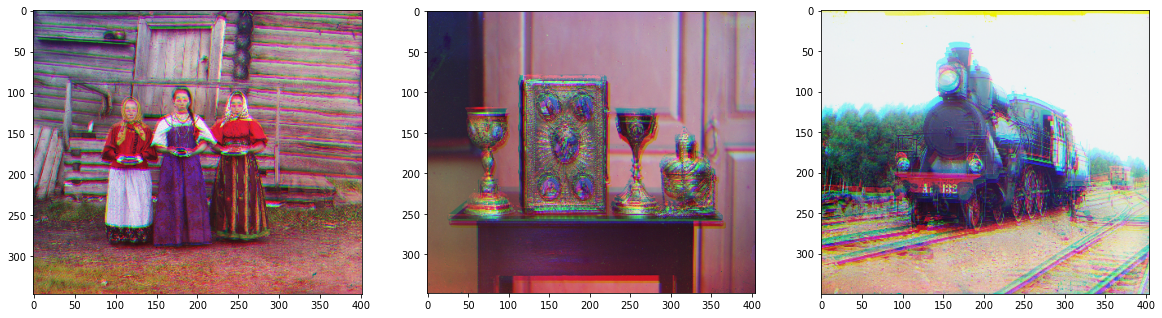

In [5]:
rgb_imgs = list(map(impose_components, images))
visualize(rgb_imgs)

### Поиск наилучшего сдвига для выравнивания каналов.

Чтобы выровнять два канала, надо сдвигать один канал относительно другого в некоторых пределах (например, от $-15$ до $15$ пикселей) и запомнить сдвиг с наибольшей похожестью.

**Kорреляция изображений:**
>    Если представить каждое изображение (канал) в виде многомерного вектора, то наша мера похожести - это скалярное произведение, упрощенно - проекция одного вектора на другой. Т.е. чем ближе два вектора, тем больше значение нашей функции.

Для каждого сдвига надо рассчитать некоторые метрики в перекрытии изображений.
>В зависимости от метрик лучшим сдвигом является тот, для которого метрика достигает наибольшего или наименьшего значения. Есть две метрики, которые позволяют получить лучшее качество выравнивания:

Mean squared error (MSE):
$$ MSE(I_1, I_2) = \dfrac{1}{w * h}\sum_{x,y}(I_1(x,y)-I_2(x,y))^2, $$
Normalized cross-correlation (CC):
$$ I_1 \ast I_2 = \dfrac{\sum_{x,y}I_1(x,y)I_2(x,y)}{\sum_{x,y}I_1(x,y)\sum_{x,y}I_2(x,y)}. $$
>w, h-ширина и высота изображений соответственно. Чтобы найти оптимальный сдвиг, надо найти минимальный MSE по всем значениям сдвига.



In [6]:
def mse(X, Y):
    return np.mean((X - Y)**2)
    
def cross_correlation(X, Y):
    return abs(np.sum(X*Y) / (np.sum(X) * np.sum(Y)))

def correlation(X, Y):
    return (X*Y).sum()

In [8]:
def shift_channel(movable_channel, dx, dy):
    return np.roll(movable_channel, (dx, dy), axis=(0,1))

def bruteforce_shifts_search(fixed_channel, movable_channel,
                             *,
                             metric=correlation, maximize=True,
                             dx_search_range=range(-15, 15),
                             dy_search_range=range(-15, 15)):
    """ 
    Находит лучший сдвиг для каналов
    
    params:  fixed_channel (np.array)
             movable_channel (np.array)
             metric (function) {correlation, mse, cross_correlation}
             maximize (bool)
             dx_search_range (range) {-15:15}
             dy_search_range (range) {-15:15}
    
    return:  best_dx (int) in dx_search_range - лучший сдвиг по горизонтали (axis=0)
             best_dy (int) in dy_search_range - лучший сдвиг по вертикали   (axis=1)
    
    warning: Не работает на больших изображениях (+500px), так как там требуется более большой сдвиг каналов
    """
    def _comparison(X, Y):
        if maximize: return X > Y
        else: return X < Y

    best_dx, best_dy = 0, 0
    best_metric_result =  metric(movable_channel, fixed_channel)

    for dx in dx_search_range:
        for dy in dy_search_range:
            
            tmp = shift_channel(movable_channel, dx, dy)
            metric_result = metric(tmp, fixed_channel)

            if _comparison(metric_result, best_metric_result):
                best_dx = dx
                best_dy = dy
                best_metric_result = metric_result
    return best_dx, best_dy


def get_best_image(rgb_img):
    final_img = np.zeros(rgb_img.shape, dtype=np.int32)
    r, g, b = rgb_img[..., 0], rgb_img[..., 1], rgb_img[..., 2]
    
    ##~~~~~~~~~~~~~~~~~~~~~ fixed red channel
    final_img[..., 0] = r
    
    ##~~~~~~~~~~~~~~~~~~~~~ move green channel
    dx, dy = bruteforce_shifts_search(r, movable_channel=g, metric=correlation, maximize=True)
    final_img[..., 1] = shift_channel(g, dx, dy)

    ##~~~~~~~~~~~~~~~~~~~~~ move blue channel
    dx, dy = bruteforce_shifts_search(g, movable_channel=b, metric=correlation, maximize=True)
    final_img[..., 2] = shift_channel(b, dx, dy) 
    return final_img

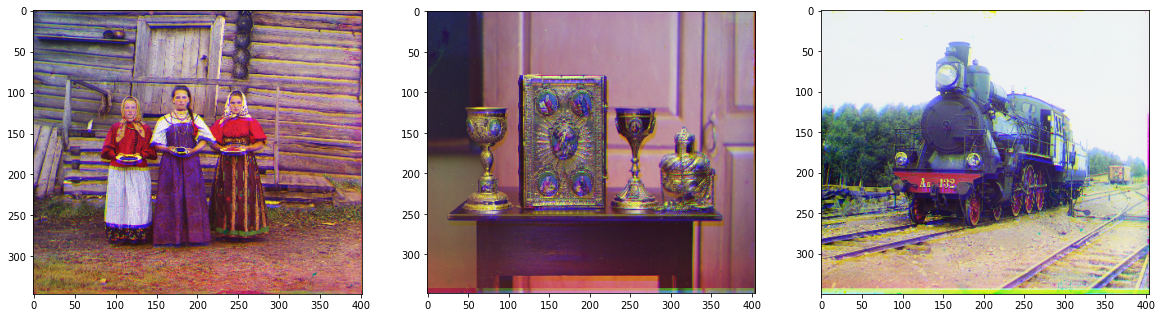

In [9]:
final_imgs = list(map(get_best_image, rgb_imgs))
visualize(final_imgs)

### Работа с большими изображениями

    big_test.tif весит примерно 60mb, размер цветного изображения (2959, 3286, 3)
    Очевидно, что `bruteforce_shifts_search` не сможет быстро найти нужный сдвиг.

In [10]:
import cv2
img = cv2.imread('big_test.tif',0)
rgb_img = impose_components(img, cut=0.05)

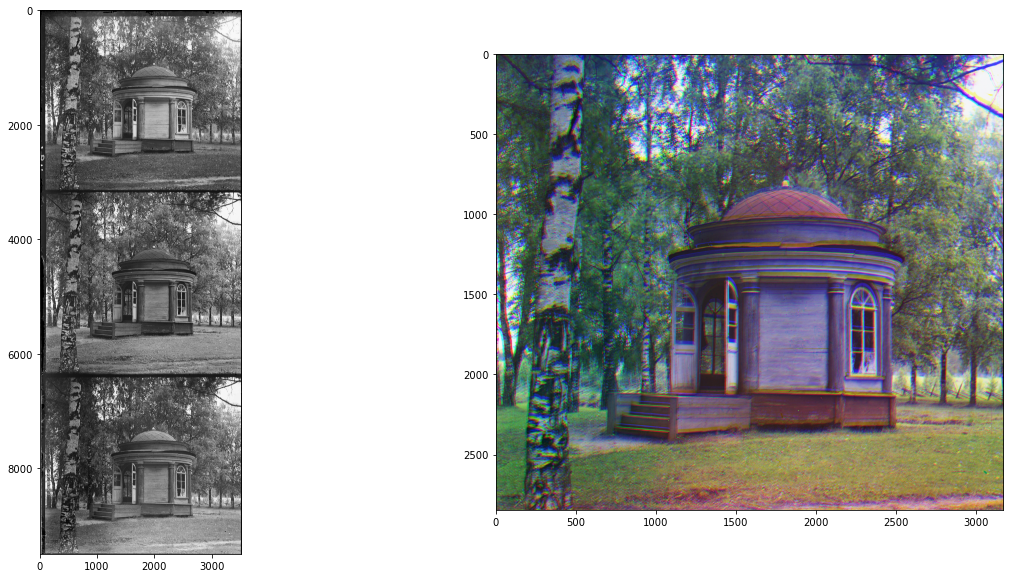

In [11]:
plt.figure(figsize = (20, 10))
plt.subplot(1, 2, 1)    
plt.imshow(img, cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(rgb_img)
plt.show()

### Пирамида изображений 

**Описание** https://ru.wikipedia.org/wiki/Пирамида_изображений
>По своей сути пирамида изображений может рассматриваться как набор представлений, упорядоченный в форме вертикальной иерархии по мере уменьшения некоего масштаба. 
<br>
Обычно в основании пирамиды располагается оригинальное изображение высокого разрешения, а по мере движения вверх масштаб и разрешение уменьшаются.
<br>
В результате, на вершине оказывается самое грубое приближение с низким качеством и информативностью.

In [16]:
def сreate_image_pyramid(channel, depth=5):
    return tuple(sk.transform.pyramid_gaussian(channel,
                                               max_layer=depth,
                                               downscale=2,
                                               multichannel=False))

def pyramid_shifts_search(fixed_channel, movable_channel, *, pyramid_depth=5):
    """ 
    Находит лучший сдвиг, использует пирамиду изображений для решения проблемы.
    
    params:  fixed_channel   (np.array)
             movable_channel (np.array)
    
    return:  best_dx (int) - лучший сдвиг по горизонтали (axis=1)
             best_dy (int) - лучший сдвиг по вертикали (axis=0)
    """
    pyramid_fixed_channel   = сreate_image_pyramid(fixed_channel, pyramid_depth)
    pyramid_movable_channel = сreate_image_pyramid(movable_channel, pyramid_depth)
    
    dx_dynamic_range = range(-15, 15+1)
    dy_dynamic_range = range(-15, 15+1)
    
    for lvlMovable, lvlFixed in reversed(tuple(zip(pyramid_movable_channel, pyramid_fixed_channel))):
        
        best_dx, best_dy = bruteforce_shifts_search(lvlFixed,
                                                    movable_channel=lvlMovable,
                                                    dx_search_range=dx_dynamic_range,
                                                    dy_search_range=dy_dynamic_range)
        # Переход к увеличенному изображению
        dx_dynamic_range = range(best_dx * 2 - 2, best_dx * 2 + 3)
        dy_dynamic_range = range(best_dy * 2 - 2, best_dy * 2 + 3)
    return best_dx, best_dy

def get_best_image2(rgb_img):
    def _cut(img):
        return img[result_height_cut: -result_height_cut,
                    result_width_cut: -result_width_cut]
    
    final_img = np.zeros(rgb_img.shape, dtype=np.int32)
    result_width_cut = 0
    result_height_cut = 0
    
    r, g, b = rgb_img[..., 0], rgb_img[..., 1], rgb_img[..., 2]
    
    ##~~~~~~~~~~~~~~~~~~~~~ fixed red channel
    final_img[..., 0] = r

    ##~~~~~~~~~~~~~~~~~~~~~ move green channel
    dx, dy = pyramid_shifts_search(r, movable_channel=g)    
    final_img[..., 1] = shift_channel(g, dx, dy)
    result_height_cut, result_width_cut = dx, dy

    ##~~~~~~~~~~~~~~~~~~~~~ move blue channel
    dx, dy = pyramid_shifts_search(r, movable_channel=b)
    final_img[..., 2] = shift_channel(b, dx, dy)
    
    result_height_cut = max(abs(dx), abs(result_height_cut))
    result_width_cut  = max(abs(dy), abs(result_width_cut))
    return _cut(final_img)

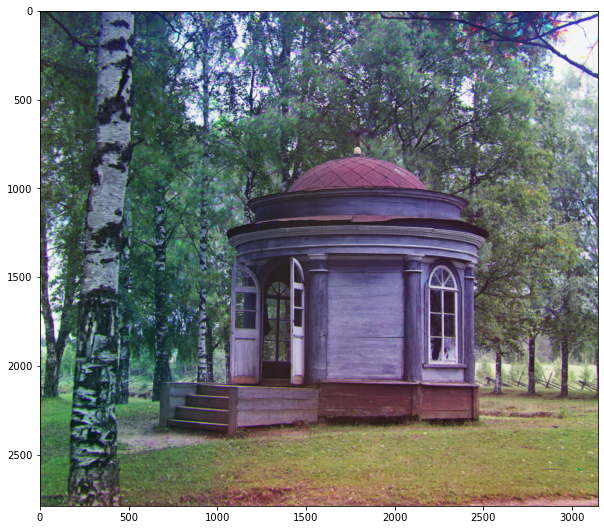

Wall time: 6.49 s


In [17]:
%%time
final_img = get_best_image2(rgb_img)
visualize(final_img, scale=0.5)